# Group Members:<br>
+ Zahra Hoobakht

In [1]:
#%pip install tensorflow
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from keras import metrics
from sklearn import metrics as mt
import tensorflow as tf
from tensorflow import keras
import os
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import cv2
import glob
import random

import warnings

import copy
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN


## Preparation (3 points total)
[2 points] Define and prepare your data set. Provide details about the source of the data. Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  Also discuss your rationale for the size and nature of your vocabulary.

This dataset is to recognize and classify the Spam text messages and ham messages. In the context of recognizing and classifying spam and ham text messages, the tokenization method used is typically word-based tokenization. In this approach, each word in the text is treated as a separate token, which allows the model to capture the semantic meaning of the text more effectively.To prepare the data for training, the text messages are typically preprocessed by removing any unnecessary characters or punctuation, and then splitting the text into individual words using a tokenizer. Stop words such as "the", "a", and "and" are often removed as they are not useful for distinguishing between spam and ham messages.

Once the messages have been tokenized, they are typically represented as a sequence of integers that correspond to the index of each word in a pre-defined vocabulary. The size and nature of the vocabulary will depend on the specific dataset and task, but may include commonly used words as well as domain-specific terms.

Because the length of the text messages can vary, it is often necessary to force a specific length of sequence for input data. This can be done using padding or truncation, where messages are either padded with zeros to a fixed length or truncated to a maximum length. The choice of sequence length and vocabulary size can have a significant impact on model performance. In general, longer sequences and larger vocabularies can improve model accuracy but may also increase training time and computational complexity.

https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

In [2]:
df = pd.read_csv('C://Users/Hedieh/Documents/SMU/ML-Py/lab7/SPAMtextmessage.csv',encoding='latin1')

In [3]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Our Category column contains of binary values of ham and Spam which is considered as our categorical data and we should do one-hot-encoding. so for now I am changing ham to 0 and spam to 1 and in the next part I change them to one-hot-encoding

In [4]:
df.Category.replace(to_replace = ['ham', 'spam'], value = range(0,2), inplace = True)
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ã¼ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   int64 
 1   Message   5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [6]:
df['Category'].value_counts()

0    4825
1     747
Name: Category, dtype: int64

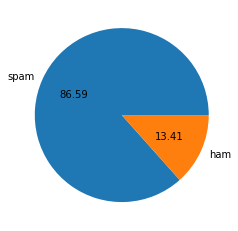

In [7]:
plt.pie(df['Category'].value_counts(),labels=['spam','ham'],autopct='%0.2f')
plt.show()

In [8]:
from sklearn.utils import Bunch

bunch = Bunch(data=df["Message"].values,
              target=df["Category"].values,
              target_names=["ham", "spam"],
              DESCR="My custom dataset")


In [9]:
import numpy as np

# display a random document and label
idx = round(np.random.rand()*len(bunch.data))

print('--------Random Document---------')
print('================================')
print('Document Label: ',bunch.target_names[bunch.target[idx]])
print('================================')
print("\n".join(bunch.data[idx].split("\n")))

--------Random Document---------
Document Label:  ham
I have no idea where you are


The nature of the vocabulary in the ham or spam message classification task is skewed towards certain words that are more common in one type of message than the other. For example, spam messages contain more advertisements, scam attempts, and unsolicited promotions, while ham messages contain more personal or business communications

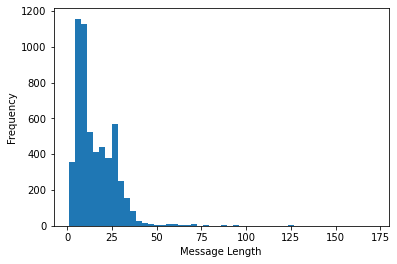

Max message length: 181


In [10]:
df['message_length'] = df['Message'].apply(lambda x: len(x.split()))
# Plot a histogram of message lengths
plt.hist(df['message_length'], bins=50)
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# Determine an appropriate sequence length based on the histogram
max_len = df['message_length'].max() + 10 # Add some extra padding
print('Max message length:', max_len)

this graph shows that our maximum message length is 181 but most of our message frequent words are in the first 50 sequence. so I am considering 50 as the length of message to minimize padding and reduce the computational requirements for training the model.

In [11]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 50 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(bunch.data)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(bunch.data)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(bunch.target)
print('Shape of data tensor:', X.shape)
# print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 9008 unique tokens. Distilled to 9008 top words.
Shape of data tensor: (5572, 50)
9008
Wall time: 269 ms


In [12]:
vocab_size = len(word_index)
vocab_size

9008

The representation is now:

+ each word is converted to an integer
+ each article is a series of integers that represent the correct ordering of words
+ the target is one hot encoded

In [13]:
del df['message_length']

In [14]:
df_one_hot = pd.concat([df, pd.DataFrame(y_ohe, columns=['onehotcode'+str(i) for i in range(y_ohe.shape[1])])], axis=1)
df_one_hot

,Category,Message,onehotcode0,onehotcode1
0,0,"Go until jurong point, crazy.. Available only ...",1.0,0.0
1,0,Ok lar... Joking wif u oni...,1.0,0.0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.0,1.0
3,0,U dun say so early hor... U c already then say...,1.0,0.0
4,0,"Nah I don't think he goes to usf, he lives aro...",1.0,0.0
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,0.0,1.0
5568,0,Will Ã¼ b going to esplanade fr home?,1.0,0.0
5569,0,"Pity, * was in mood for that. So...any other s...",1.0,0.0
5570,0,The guy did some bitching but I acted like i'd...,1.0,0.0


In [15]:
word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'in': 8,
 'is': 9,
 'me': 10,
 'my': 11,
 'for': 12,
 'your': 13,
 'it': 14,
 'of': 15,
 'call': 16,
 'have': 17,
 'on': 18,
 '2': 19,
 'that': 20,
 'now': 21,
 'are': 22,
 'so': 23,
 'but': 24,
 'not': 25,
 'or': 26,
 'do': 27,
 'can': 28,
 'at': 29,
 "i'm": 30,
 'ur': 31,
 'get': 32,
 'will': 33,
 'if': 34,
 'be': 35,
 'with': 36,
 'just': 37,
 'no': 38,
 'we': 39,
 'this': 40,
 '4': 41,
 'gt': 42,
 'lt': 43,
 'up': 44,
 'when': 45,
 'ok': 46,
 'free': 47,
 'from': 48,
 'go': 49,
 'how': 50,
 'all': 51,
 'out': 52,
 'what': 53,
 'know': 54,
 'like': 55,
 'good': 56,
 'then': 57,
 'got': 58,
 'come': 59,
 'was': 60,
 'its': 61,
 'am': 62,
 'time': 63,
 'day': 64,
 'only': 65,
 'love': 66,
 'there': 67,
 'send': 68,
 'he': 69,
 'want': 70,
 'text': 71,
 'as': 72,
 'txt': 73,
 'one': 74,
 'going': 75,
 'by': 76,
 "i'll": 77,
 'need': 78,
 'home': 79,
 'about': 80,
 'r': 81,
 'lor': 82,
 'sorry': 83,
 'still': 84,
 's

[0.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[0.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

for this work, as I have unbalanced data, I should use cross validation to make sure the proportion of each class is maintained in both the training and validation/test sets. This helps to ensure that the model learns from all the classes and performs well on unseen data. also accuracy may not be the best metric to evaluate the model performance. This is because the model may tend to predict the majority class most of the time, leading to a high accuracy even if the minority class is misclassified.
In such scenarios, it is better to use evaluation metrics that take into account the imbalance of the target classes, such as precision, recall, F1-score, and area under the ROC curve (AUC-ROC). I will use recall for this lab to minimize false negatives, in this way I will minimize the rate of spam messages which is predicted as ham.


In [16]:

skf = StratifiedKFold(n_splits=5)
#target = df.loc[:, 'Category']

y = np.argmax(y_ohe, axis=1) # convert one-hot encoding to original labels

X_train=[]
y_train=[]
X_test=[]
y_test=[]

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    
    Xtrain, ytrain = X[train_index], y[train_index]
    Xtest, ytest = X[test_index], y[test_index]
    X_train.append(Xtrain)
    X_test.append(Xtest)
    y_train.append(ytrain)
    y_test.append(ytest)
    
    print('Class Ratio (Fold {}): {:.2f}'.format(len(X_train), sum(ytest)/(len(ytest))))
 



Class Ratio (Fold 1): 0.13
Class Ratio (Fold 2): 0.13
Class Ratio (Fold 3): 0.13
Class Ratio (Fold 4): 0.13
Class Ratio (Fold 5): 0.13


In [17]:

print(type(X_train[0]), X_train[0].shape)
print('Vocabulary size:', np.max(X_train[0]))
print(y_train[0].shape, np.min(y_train[0]), np.max(y_train[0]))

<class 'numpy.ndarray'> (4457, 50)
Vocabulary size: 9008
(4457,) 0 1


## Modeling (6 points total)

[2 points] Investigate at least two different recurrent network architectures  Be sure to use an embedding layer . Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them. Justify your choice of parameters for each.

In [18]:
df_X_train = pd.DataFrame(X_train[0])
df_X_train

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,273,16,3441,48,679,311,129,3442,2634,65
1,0,0,0,0,0,0,0,0,0,0,...,13,792,327,1842,625,1843,2640,530,1844,1845
2,0,0,0,0,0,0,0,0,0,0,...,3,17,191,4,273,367,159,26,588,154
3,0,0,0,0,0,0,0,0,0,0,...,18,428,1624,16,748,18,782,26,16,1728
4,0,0,0,0,0,0,0,0,0,0,...,143,1092,243,196,723,1439,1603,1604,231,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4452,0,0,0,0,0,0,0,0,0,0,...,16,9004,9005,65,529,235,646,354,557,391
4453,0,0,0,0,0,0,0,0,0,0,...,0,0,33,119,183,75,2,2048,862,79
4454,0,0,0,0,0,0,0,0,0,0,...,9006,60,8,1327,12,20,23,106,250,9007
4455,0,0,0,0,0,0,0,0,0,0,...,214,112,7,69,1041,14,2,198,12,47


In [19]:
bunch = Bunch(data=df["Message"].values,
              target=df["Category"].values,
              target_names=["ham", "spam"],
              DESCR="My custom dataset")

In [20]:
top_words

9008

In [21]:
EMBED_SIZE =100
RNN_STATESIZE = 64
#rnns = []
input_holder = Input(shape=(X_train[0].shape[1], ))
shared_embed = Embedding(top_words+1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=X_train[0].shape[1])(input_holder) # number of words in each sequence


x = SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(1, activation='sigmoid')(x)
simple_rnn_model = Model(inputs=input_holder,outputs=x)

In [22]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)

simple_rnn_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=[metrics.Recall()])
print(simple_rnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           900900    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 911,525
Trainable params: 911,525
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
X_test[0].shape

(1115, 50)

In [24]:
y_train[0].shape

(4457,)

In [25]:
history1=simple_rnn_model.fit(X_train[0], y_train[0], epochs=50, batch_size=40, validation_data=(X_test[0], y_test[0]))

Epoch 1/50
112/112 [==============================] - 8s 35ms/step - loss: 0.6270 - recall: 0.3585 - val_loss: 0.3870 - val_recall: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 4s 32ms/step - loss: 0.3956 - recall: 0.0285 - val_loss: 0.3950 - val_recall: 0.0000e+00
Epoch 3/50
112/112 [==============================] - 4s 33ms/step - loss: 0.3447 - recall: 0.1792 - val_loss: 0.2541 - val_recall: 0.4067
Epoch 4/50
112/112 [==============================] - 4s 32ms/step - loss: 0.2919 - recall: 0.3936 - val_loss: 0.1913 - val_recall: 0.5267
Epoch 5/50
112/112 [==============================] - 4s 32ms/step - loss: 0.2088 - recall: 0.6315 - val_loss: 0.1367 - val_recall: 0.7267
Epoch 6/50
112/112 [==============================] - 4s 32ms/step - loss: 0.1680 - recall: 0.6985 - val_loss: 0.1485 - val_recall: 0.6333
Epoch 7/50
112/112 [==============================] - 4s 32ms/step - loss: 0.1362 - recall: 0.7554 - val_loss: 0.1031 - val_recall: 0.7800
Epoch 8/50
112/112 

Text(0.5, 0, 'epochs')

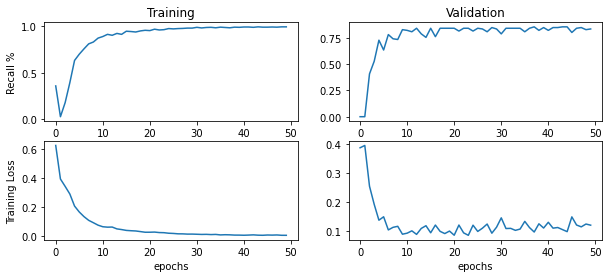

In [26]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history1.history['recall'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history1.history['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs')

In [27]:
EMBED_SIZE = 100
RNN_STATESIZE = 64

input_holder = Input(shape=(X_train[0].shape[1], ))
shared_embed = Embedding(top_words+1, EMBED_SIZE, input_length=X_train[0].shape[1])(input_holder)

x = SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(shared_embed)
x = SimpleRNN(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dense(1, activation='sigmoid')(x)
simple_rnn_model2 = Model(inputs=input_holder,outputs=x)


In [28]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)

simple_rnn_model2.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=[metrics.Recall()])
print(simple_rnn_model2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           900900    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 64)            10560     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 919,781
Trainable params: 919,781
Non-trainable params: 0
_________________________________________________________________
None


for my second model, I have added another SimpleRNN layer with the parameter return_sequences=True to return the output of each time step to the next layer. This allows the next layer to process the sequence of outputs from the first RNN layer. The second SimpleRNN layer then processes the sequence and produces a final output that is passed through the dense layer with the sigmoid activation function.

In [29]:
history2=simple_rnn_model2.fit(X_train[0], y_train[0], epochs=50, batch_size=40, validation_data=(X_test[0], y_test[0]))

Epoch 1/50
112/112 [==============================] - 8s 49ms/step - loss: 0.6446 - recall_1: 0.4003 - val_loss: 0.3966 - val_recall_1: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 5s 46ms/step - loss: 0.3953 - recall_1: 0.0419 - val_loss: 0.4610 - val_recall_1: 0.0000e+00
Epoch 3/50
112/112 [==============================] - 5s 47ms/step - loss: 0.3472 - recall_1: 0.1139 - val_loss: 0.4914 - val_recall_1: 0.0000e+00
Epoch 4/50
112/112 [==============================] - 5s 47ms/step - loss: 0.2771 - recall_1: 0.3735 - val_loss: 0.2864 - val_recall_1: 0.3000
Epoch 5/50
112/112 [==============================] - 5s 47ms/step - loss: 0.2198 - recall_1: 0.5779 - val_loss: 0.3300 - val_recall_1: 0.2733
Epoch 6/50
112/112 [==============================] - 5s 46ms/step - loss: 0.1667 - recall_1: 0.6851 - val_loss: 0.1981 - val_recall_1: 0.5467
Epoch 7/50
112/112 [==============================] - 5s 46ms/step - loss: 0.1313 - recall_1: 0.7722 - val_loss: 0.1948 - val_reca

Text(0.5, 0, 'epochs')

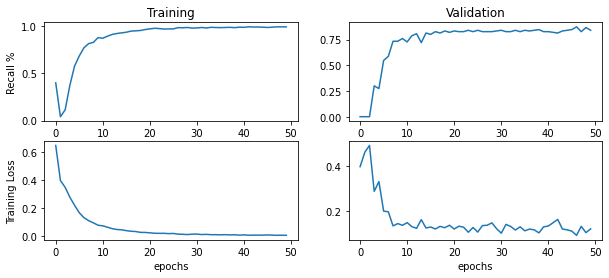

In [30]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history2.history['recall_1'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history2.history['val_recall_1'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history2.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history2.history['val_loss'])
plt.xlabel('epochs')

for my third model I am using LSTM

In [31]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# create LSTM
x = LSTM(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(1, activation='sigmoid')(x)
lstm_model = Model(inputs=input_holder,outputs=x)

In [32]:
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
lstm_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=[metrics.Recall()])

In [33]:
print(lstm_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           900900    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 943,205
Trainable params: 943,205
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
history3=lstm_model.fit(X_train[0], y_train[0], epochs=50, batch_size=40, validation_data=(X_test[0], y_test[0]))

Epoch 1/50
112/112 [==============================] - 11s 70ms/step - loss: 0.5949 - recall_2: 0.1390 - val_loss: 0.3657 - val_recall_2: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 8s 71ms/step - loss: 0.2960 - recall_2: 0.0117 - val_loss: 0.2305 - val_recall_2: 0.0600
Epoch 3/50
112/112 [==============================] - 8s 69ms/step - loss: 0.1637 - recall_2: 0.5729 - val_loss: 0.1387 - val_recall_2: 0.8000
Epoch 4/50
112/112 [==============================] - 9s 79ms/step - loss: 0.1013 - recall_2: 0.8392 - val_loss: 0.1325 - val_recall_2: 0.7333
Epoch 5/50
112/112 [==============================] - 8s 71ms/step - loss: 0.0742 - recall_2: 0.8844 - val_loss: 0.0924 - val_recall_2: 0.8467
Epoch 6/50
112/112 [==============================] - 9s 76ms/step - loss: 0.0665 - recall_2: 0.8995 - val_loss: 0.0820 - val_recall_2: 0.8733
Epoch 7/50
112/112 [==============================] - 8s 72ms/step - loss: 0.0508 - recall_2: 0.9313 - val_loss: 0.0741 - val_recall_2: 0

Text(0.5, 0, 'epochs')

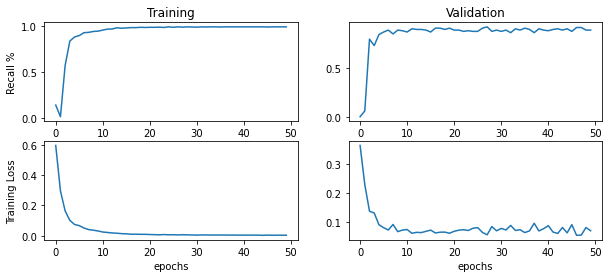

In [35]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history3.history['recall_2'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history3.history['val_recall_2'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history3.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history3.history['val_loss'])
plt.xlabel('epochs')

for my forth model I am using GRU

In [36]:
# create GRU
x = GRU(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(1, activation='sigmoid')(x)
gru_model = Model(inputs=input_holder,outputs=x)

In [37]:
print(gru_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           900900    
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 932,837
Trainable params: 932,837
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
gru_model.compile(loss='binary_crossentropy', 
              optimizer= opt, 
              metrics=[metrics.Recall()])

In [39]:
history4=gru_model.fit(X_train[0], y_train[0], epochs=50, batch_size=40, validation_data=(X_test[0], y_test[0]))

Epoch 1/50
112/112 [==============================] - 10s 65ms/step - loss: 0.6440 - recall_3: 0.1374 - val_loss: 0.5791 - val_recall_3: 0.0733
Epoch 2/50
112/112 [==============================] - 7s 65ms/step - loss: 0.4190 - recall_3: 0.1340 - val_loss: 0.2247 - val_recall_3: 0.0267
Epoch 3/50
112/112 [==============================] - 7s 63ms/step - loss: 0.1426 - recall_3: 0.4405 - val_loss: 0.1157 - val_recall_3: 0.7333
Epoch 4/50
112/112 [==============================] - 7s 64ms/step - loss: 0.0596 - recall_3: 0.8744 - val_loss: 0.0749 - val_recall_3: 0.8400
Epoch 5/50
112/112 [==============================] - 7s 65ms/step - loss: 0.0267 - recall_3: 0.9698 - val_loss: 0.0571 - val_recall_3: 0.8933
Epoch 6/50
112/112 [==============================] - 7s 63ms/step - loss: 0.0144 - recall_3: 0.9849 - val_loss: 0.0628 - val_recall_3: 0.8933
Epoch 7/50
112/112 [==============================] - 7s 66ms/step - loss: 0.0106 - recall_3: 0.9916 - val_loss: 0.0522 - val_recall_3: 0.920

Text(0.5, 0, 'epochs')

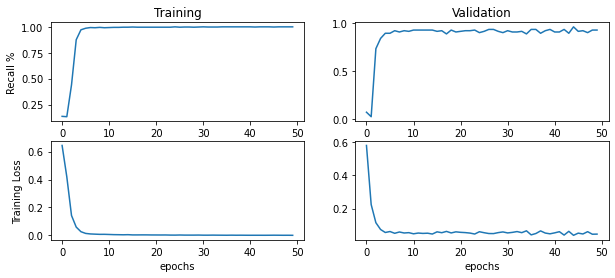

In [40]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history4.history['recall_3'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history4.history['val_recall_3'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history4.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history4.history['val_loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

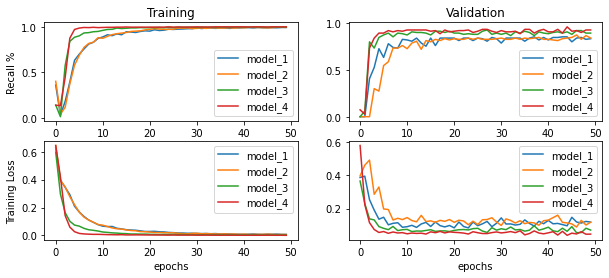

In [41]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history1.history['recall'],label='model_1')
plt.plot(history2.history['recall_1'],label='model_2')
plt.plot(history3.history['recall_2'],label='model_3')
plt.plot(history4.history['recall_3'],label='model_4')
plt.legend()

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history1.history['val_recall'],label='model_1')
plt.plot(history2.history['val_recall_1'],label='model_2')
plt.plot(history3.history['val_recall_2'],label='model_3')
plt.plot(history4.history['val_recall_3'],label='model_4')
plt.legend()
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history['loss'],label='model_1')
plt.plot(history2.history['loss'],label='model_2')
plt.plot(history3.history['loss'],label='model_3')
plt.plot(history4.history['loss'],label='model_4')
plt.legend()
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history['val_loss'],label='model_1')
plt.plot(history2.history['val_loss'],label='model_2')
plt.plot(history3.history['val_loss'],label='model_3')
plt.plot(history4.history['val_loss'],label='model_4')
plt.legend()
plt.xlabel('epochs')

SimpleRNN, LSTM (Long Short-Term Memory), and GRU (Gated Recurrent Unit) are all types of RNNs, but they have different architectures and behaviors, which result in differences in their performance and capabilities.

SimpleRNN:
SimpleRNN is the most basic type of RNN. It processes the current input and the previous hidden state to produce the current output and a new hidden state. However, it suffers from the vanishing gradient problem and is not very good at capturing long-term dependencies in the data.

SimpleRNN-LSTM:
LSTM is a type of RNN that is designed to address the vanishing gradient problem and capture long-term dependencies. It has an additional memory cell and three gates (input, forget, and output) that control the flow of information. The input gate regulates the flow of new input to the memory cell, the forget gate regulates the retention of old memory, and the output gate regulates the output of the memory cell. This allows LSTM to remember important information over longer periods of time and forget irrelevant information.

SimpleRNN-GRU:
GRU is another type of RNN that is similar to LSTM but has a simpler architecture. It has two gates (update and reset) that control the flow of information. The update gate determines how much of the new input should be added to the previous memory, while the reset gate determines how much of the previous memory should be forgotten. GRU is generally faster and more efficient than LSTM, but may not be as effective at capturing long-term dependencies.

In summary, SimpleRNN is a basic RNN that may not be very good at capturing long-term dependencies. LSTM and GRU are more advanced RNNs that are designed to address the vanishing gradient problem and capture long-term dependencies. LSTM has a more complex architecture with three gates, while GRU has a simpler architecture with two gates. Our results show that GRU has better training and validation recall and after that is LSTM.

In [42]:
# this operation can take time 
yhat_rnn = simple_rnn_model.predict(X_test[0])
yhat_rnn2 = simple_rnn_model2.predict(X_test[0])
yhat_lstm = lstm_model.predict(X_test[0])
yhat_gru = gru_model.predict(X_test[0])

35/35 [==============================] - 0s 6ms/step


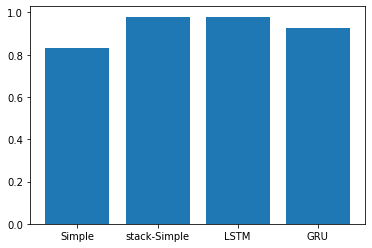

In [57]:
from sklearn import metrics as mt
from sklearn.metrics import recall_score
%matplotlib inline

acc = [recall_score(y_test[0],np.round(yhat_rnn)),
       recall_score(y_test[0],np.round(yhat_rnn2)),
       recall_score(y_test[0],np.round(yhat_lstm)),
       recall_score(y_test[0],np.round(yhat_gru)),
      ]

plt.bar([1,2,3,4],acc)
plt.xticks([1,2,3,4],['Simple','stack-Simple','LSTM','GRU'])
plt.show()

I think, this result show that during training, the model is overfitting to the training data, which can lead to high recall during training but poor generalization performance on new, unseen data. As the training loss continues to decrease, the validation loss levels off or starts to increase, it may be an indication of overfitting. Our results show that LSTM has the better performance on the training, validation and testing set 

[1 point] Use the Glove pre-trained embedding. Provide justification of the embedding size.

As for the first part, I chose first 100 Embedding sequence, to compare the result fairly, I am choosing 100. 

In [44]:
# load pre-trained embeddings
embedding_path = 'C://Users/Hedieh/Documents/SMU/ML-Py/lab7/glove.6B.100d.txt'


In [45]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open(embedding_path,encoding='utf-8')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (9009, 100) 
 Total words found: 6545 
 Percentage: 72.64957264957265
Wall time: 11.7 s


In [46]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
rnn.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=[metrics.Recall()])
print(rnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           900900    
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 981,401
Trainable params: 80,501
Non-trainable params: 900,900
_________________________________________________________________
None


In [54]:

history5 = rnn.fit(X_train[0], y_train[0], validation_data=(X_test[0], y_test[0]), epochs=50, batch_size=40)


Epoch 1/50
112/112 [==============================] - 8s 69ms/step - loss: 0.0290 - recall_5: 0.9464 - val_loss: 0.0438 - val_recall_5: 0.9400
Epoch 2/50
112/112 [==============================] - 8s 68ms/step - loss: 0.0318 - recall_5: 0.9497 - val_loss: 0.0456 - val_recall_5: 0.9333
Epoch 3/50
112/112 [==============================] - 8s 67ms/step - loss: 0.0246 - recall_5: 0.9581 - val_loss: 0.0448 - val_recall_5: 0.9400
Epoch 4/50
112/112 [==============================] - 8s 69ms/step - loss: 0.0282 - recall_5: 0.9464 - val_loss: 0.0491 - val_recall_5: 0.9400
Epoch 5/50
112/112 [==============================] - 7s 64ms/step - loss: 0.0281 - recall_5: 0.9481 - val_loss: 0.0411 - val_recall_5: 0.9400
Epoch 6/50
112/112 [==============================] - 7s 65ms/step - loss: 0.0305 - recall_5: 0.9531 - val_loss: 0.0451 - val_recall_5: 0.9333
Epoch 7/50
112/112 [==============================] - 7s 67ms/step - loss: 0.0277 - recall_5: 0.9598 - val_loss: 0.0451 - val_recall_5: 0.9133

Text(0.5, 0, 'epochs')

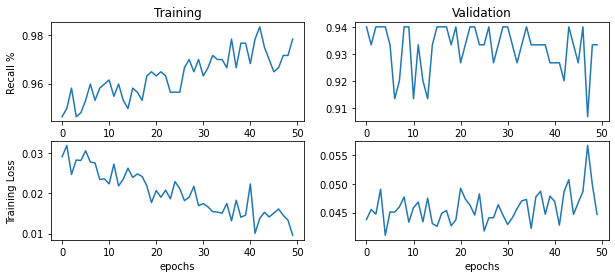

In [55]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history5.history['recall_5'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history5.history['val_recall_5'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history5.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history5.history['val_loss'])
plt.xlabel('epochs')

[1 points] Using the best parameters and architecture from the RNN in the previous step, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

as my LSTM has a good training, validation and test recall score. I am going to choose LSTM as the first recurrent network

In [62]:

# create LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(RNN_STATESIZE,dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
rnn.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=[metrics.Recall()])
print(rnn.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           900900    
                                                                 
 lstm_9 (LSTM)               (None, 50, 64)            42240     
                                                                 
 lstm_10 (LSTM)              (None, 100)               66000     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,009,241
Trainable params: 108,341
Non-trainable params: 900,900
_________________________________________________________________
None


In [63]:

history6 = rnn.fit(X_train[0], y_train[0], validation_data=(X_test[0], y_test[0]), epochs=50, batch_size=40)


Epoch 1/50
112/112 [==============================] - 33s 194ms/step - loss: 0.4761 - recall_6: 0.0268 - val_loss: 0.3394 - val_recall_6: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 20s 181ms/step - loss: 0.2476 - recall_6: 0.3434 - val_loss: 0.1238 - val_recall_6: 0.7533
Epoch 3/50
112/112 [==============================] - 19s 170ms/step - loss: 0.1324 - recall_6: 0.7923 - val_loss: 0.0977 - val_recall_6: 0.8400
Epoch 4/50
112/112 [==============================] - 20s 180ms/step - loss: 0.1112 - recall_6: 0.8275 - val_loss: 0.0889 - val_recall_6: 0.8667
Epoch 5/50
112/112 [==============================] - 20s 175ms/step - loss: 0.1010 - recall_6: 0.8392 - val_loss: 0.0822 - val_recall_6: 0.8800
Epoch 6/50
112/112 [==============================] - 20s 183ms/step - loss: 0.0930 - recall_6: 0.8442 - val_loss: 0.0763 - val_recall_6: 0.8600
Epoch 7/50
112/112 [==============================] - 20s 181ms/step - loss: 0.0887 - recall_6: 0.8559 - val_loss: 0.0739 - va

Text(0.5, 0, 'epochs')

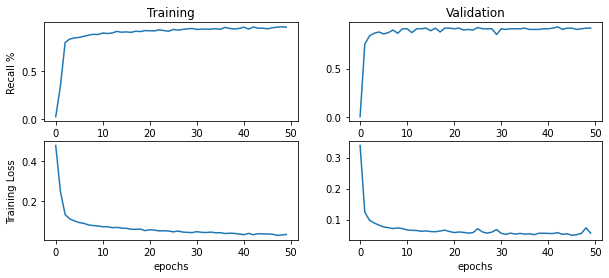

In [64]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history6.history['recall_6'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history6.history['val_recall_6'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history6.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history6.history['val_loss'])
plt.xlabel('epochs')

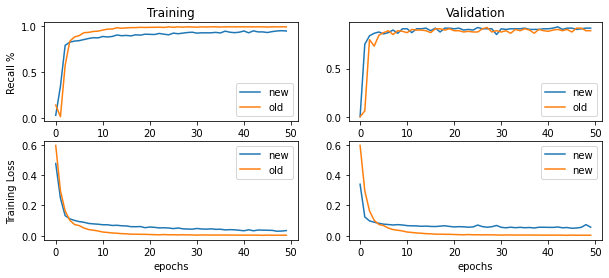

In [85]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history6.history['recall_6'],label='new')
plt.plot(history3.history['recall_2'],label='old')
plt.ylabel('Recall %')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history6.history['val_recall_6'],label='new')
plt.plot(history3.history['val_recall_2'],label='old')
plt.title('Validation')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history6.history['loss'],label='new')
plt.plot(history3.history['loss'],label='old')
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history6.history['val_loss'],label='new')
plt.plot(history3.history['loss'],label='new')
plt.xlabel('epochs')
plt.legend()

this graph shows that the recall training of old model(LSTM without Glove) is doing better job rather than our new combined model and has better training loss and validation (less overfitting)

I was curious to see what would happen if I concatenate two RNN networks so that's why I tried below code

In [73]:
input_holder = Input(shape=(X_train[0].shape[1], ))
shared_embed = Embedding(top_words+1, EMBED_SIZE, input_length=X_train[0].shape[1])(input_holder)
# create LSTM
x = LSTM(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(shared_embed)


embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)(input_holder )

x1=LSTM(100,dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
concat=tf.keras.layers.Concatenate()([x,x1])
output = Dense(1, activation='sigmoid')(concat)
lstm_model3 = Model(inputs=input_holder,outputs=output)
opt = Adam(learning_rate=0.0001, epsilon=0.0001, clipnorm=1.0)
lstm_model3.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=[metrics.Recall()])
print(lstm_model3.summary())

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 50, 100)      900900      ['input_12[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, 50, 100)      900900      ['input_12[0][0]']               
                                                                                                  
 lstm_18 (LSTM)                 (None, 64)           42240       ['embedding_14[0][0]']           
                                                                                            

In [74]:

history7 = lstm_model3.fit(X_train[0], y_train[0], validation_data=(X_test[0], y_test[0]), epochs=50, batch_size=40)


Epoch 1/50
112/112 [==============================] - 33s 201ms/step - loss: 0.4703 - recall_9: 0.0503 - val_loss: 0.3323 - val_recall_9: 0.0000e+00
Epoch 2/50
112/112 [==============================] - 21s 190ms/step - loss: 0.2900 - recall_9: 0.0586 - val_loss: 0.2022 - val_recall_9: 0.3667
Epoch 3/50
112/112 [==============================] - 21s 191ms/step - loss: 0.1648 - recall_9: 0.6533 - val_loss: 0.1078 - val_recall_9: 0.8333
Epoch 4/50
112/112 [==============================] - 21s 186ms/step - loss: 0.1182 - recall_9: 0.8023 - val_loss: 0.0943 - val_recall_9: 0.8800
Epoch 5/50
112/112 [==============================] - 21s 191ms/step - loss: 0.0978 - recall_9: 0.8409 - val_loss: 0.0848 - val_recall_9: 0.8467
Epoch 6/50
112/112 [==============================] - 22s 194ms/step - loss: 0.0874 - recall_9: 0.8476 - val_loss: 0.0753 - val_recall_9: 0.8733
Epoch 7/50
112/112 [==============================] - 21s 191ms/step - loss: 0.0795 - recall_9: 0.8660 - val_loss: 0.0697 - va

Text(0.5, 0, 'epochs')

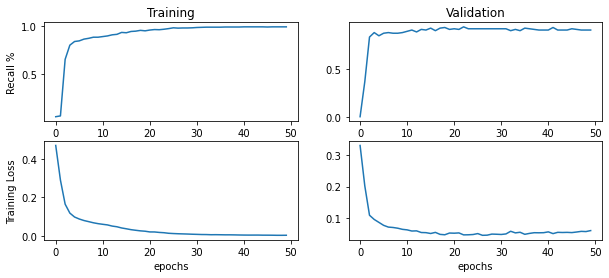

In [76]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history7.history['recall_9'])

plt.ylabel('Recall %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history7.history['val_recall_9'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history7.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history7.history['val_loss'])
plt.xlabel('epochs')

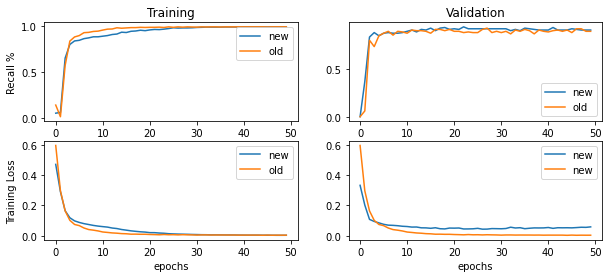

In [93]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history7.history['recall_9'],label='new')
plt.plot(history3.history['recall_2'],label='old')
plt.ylabel('Recall %')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history7.history['val_recall_9'],label='new')
plt.plot(history3.history['val_recall_2'],label='old')
plt.title('Validation')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history7.history['loss'],label='new')
plt.plot(history3.history['loss'],label='old')
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history7.history['val_loss'],label='new')
plt.plot(history3.history['loss'],label='new')
plt.xlabel('epochs')
plt.legend()

I can see an improvement but still our old setting (LSTM without Glove) works better.

## Exceptional Work (1 points total)

You have free rein to provide additional analyses.
One idea (required for 7000 level students to do one of these options):
Research and use the ConceptNet, Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 
Another Idea (NOT required): Try to create a RNN for generating novel text. 
nd GRU). Alternatively, you may also choose one recurrent network and one convolutional network.

I am going for the last option, combining GRU and convolutional network

In [124]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 100
MAX_ART_LEN = 50
RNN_STATESIZE = 64
NUM_CLASSES = 1

input_holder = Input(shape=(MAX_ART_LEN,))
embedding_layer = Embedding(top_words+1, EMBED_SIZE, input_length=MAX_ART_LEN)
embedded_sequences = embedding_layer(input_holder)
x = Conv1D(32, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(16, 5, activation='relu',
           kernel_initializer='he_uniform')(x)


# after convolution, size becomes 35 elements long
x = MaxPooling1D(3)(x) # this is the size to globally flatten 
# flattened vector max pools across each of the 35 elements
# so vectors is now 128 dimensions (same as num output filters)
x = LSTM(RNN_STATESIZE, dropout=0.2, recurrent_dropout=0.2)(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model = Model(input_holder, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.Recall()])

print(model.summary())




Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 50)]              0         
                                                                 
 embedding_34 (Embedding)    (None, 50, 100)           900900    
                                                                 
 conv1d_30 (Conv1D)          (None, 46, 32)            16032     
                                                                 
 dropout_34 (Dropout)        (None, 46, 32)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 9, 32)            0         
 g1D)                                                            
                                                                 
 dropout_35 (Dropout)        (None, 9, 32)             0         
                                                          

In [127]:
history10 = model.fit(X_train[0], y_train[0], validation_data=(X_test[0], y_test[0]),
          epochs=50, batch_size=128)

Epoch 1/50
35/35 [==============================] - 2s 56ms/step - loss: 0.0414 - recall_14: 0.9447 - val_loss: 0.0953 - val_recall_14: 0.8600
Epoch 2/50
35/35 [==============================] - 2s 58ms/step - loss: 0.0415 - recall_14: 0.9447 - val_loss: 0.0936 - val_recall_14: 0.8800
Epoch 3/50
35/35 [==============================] - 2s 55ms/step - loss: 0.0392 - recall_14: 0.9481 - val_loss: 0.0895 - val_recall_14: 0.8667
Epoch 4/50
35/35 [==============================] - 2s 56ms/step - loss: 0.0382 - recall_14: 0.9447 - val_loss: 0.0869 - val_recall_14: 0.8733
Epoch 5/50
35/35 [==============================] - 2s 58ms/step - loss: 0.0385 - recall_14: 0.9481 - val_loss: 0.0928 - val_recall_14: 0.8733
Epoch 6/50
35/35 [==============================] - 2s 54ms/step - loss: 0.0385 - recall_14: 0.9481 - val_loss: 0.0919 - val_recall_14: 0.8667
Epoch 7/50
35/35 [==============================] - 2s 56ms/step - loss: 0.0401 - recall_14: 0.9481 - val_loss: 0.0891 - val_recall_14: 0.8667

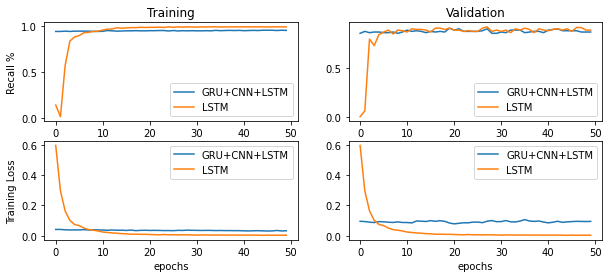

In [129]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history10.history['recall_14'],label='GRU+CNN+LSTM')
plt.plot(history3.history['recall_2'],label='LSTM')
plt.ylabel('Recall %')
plt.title('Training')
plt.legend()
plt.subplot(2,2,2)
plt.plot(history10.history['val_recall_14'],label='GRU+CNN+LSTM')
plt.plot(history3.history['val_recall_2'],label='LSTM')
plt.title('Validation')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history10.history['loss'],label='GRU+CNN+LSTM')
plt.plot(history3.history['loss'],label='LSTM')
plt.ylabel('Training Loss')
plt.xlabel('epochs')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history10.history['val_loss'],label='GRU+CNN+LSTM')
plt.plot(history3.history['loss'],label='LSTM')
plt.xlabel('epochs')
plt.legend()

In [130]:
# this operation can take time 

yhat_lstm = lstm_model.predict(X_test[0])
yhat_cnn = model.predict(X_test[0])

35/35 [==============================] - 1s 5ms/step


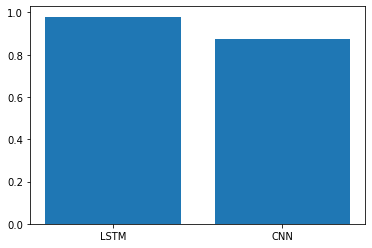

In [131]:
from sklearn import metrics as mt
from sklearn.metrics import recall_score
%matplotlib inline

acc = [recall_score(y_test[0],np.round(yhat_lstm)),
       recall_score(y_test[0],np.round(yhat_cnn))
      ]

plt.bar([1,2],acc)
plt.xticks([1,2],['LSTM','CNN'])
plt.show()

These graphs show that RNN LSTM has better recall performance rather than combined CNN and RNN.LSTM models are specifically designed to capture sequential information in data, which is often the case in natural language processing (NLP) or time-series data. On the other hand, CNN models are primarily used for image data where spatial information is important. In text classification tasks, it is more beneficial to use an LSTM to capture the sequential information in the input text. also In the CNN model, max pooling is used to downsample the feature maps and retain only the most important features. This can lead to a loss of information, especially in the early layers of the network. In contrast, the LSTM can retain all the information in the input sequence by passing it through the recurrent connections.

## Reference:
    1.lectures
    2.Dr. Larson's github